In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import timm
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, random_split , SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score

In [2]:
tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [3]:
TRAIN_DIR = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/train"
VAL_DIR = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/val"
TEST_DIR = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/test"

train_ds = ImageFolder(TRAIN_DIR, transform= tf)
val_ds =  ImageFolder(VAL_DIR, transform= tf)
test_ds = ImageFolder(TEST_DIR, transform= tf)

print(f"Training samples:   {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Number of calsses: {len(train_ds.classes)}")
print (f"calsses: {train_ds.classes}")

Training samples:   6809
Validation samples: 1454
Test samples: 1474
Number of calsses: 13
calsses: ['Mazda-2000', 'Nissan-Zamiad', 'Peugeot-206', 'Peugeot-207i', 'Peugeot-405', 'Peugeot-Pars', 'Peykan', 'Pride-111', 'Pride-131', 'Quik', 'Renault-L90', 'Samand', 'Tiba2']


In [4]:
train_loader  = DataLoader(train_ds ,  batch_size=64, shuffle= True, num_workers=4, pin_memory=True)
val_loader  = DataLoader(val_ds ,  batch_size=64, shuffle= False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds ,  batch_size=64, shuffle= False, num_workers=4, pin_memory=True)

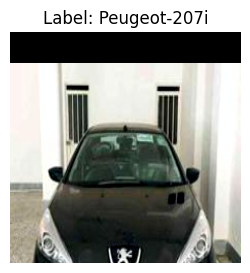

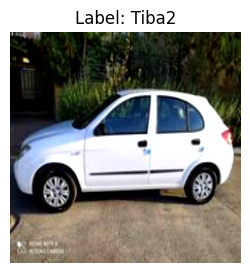

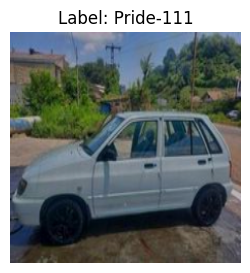

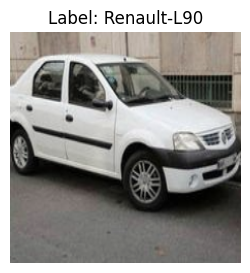

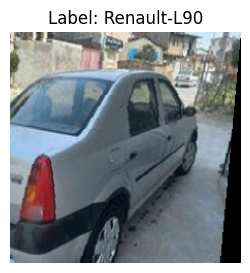

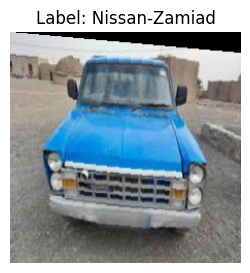

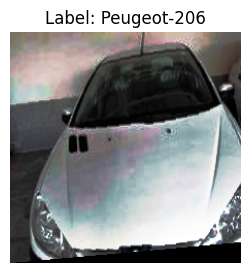

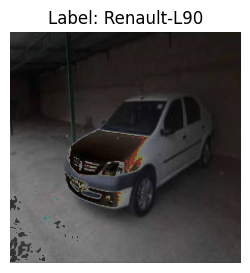

In [5]:
def show_samples(loader, num_images=8):
    """
    Display `num_images` samples from the given DataLoader.
    """
    images, labels = next(iter(loader))
    # Unnormalize parameters (assuming ImageNet normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    for idx in range(min(num_images, len(images))):
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.title(f"Label: {loader.dataset.classes[labels[idx]]}")
        plt.axis('off')
        plt.show()

show_samples(train_loader, num_images=8)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(train_ds.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [7]:
# Containers for metrics
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_top5_accs = []

# Training loop with validation
for epoch in range(1, epochs+1):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds==y).sum().item()
        total += x.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    top5_correct = 0
    with torch.no_grad():
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds==y).sum().item()
            val_total += x.size(0)
            # Top-5 accuracy
            top5 = torch.topk(logits, k=5, dim=1).indices
            top5_correct += sum([1 if y[i] in top5[i] else 0 for i in range(y.size(0))])
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    top5_acc = top5_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_top5_accs.append(top5_acc)

    scheduler.step()
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, Top-5 Acc={top5_acc:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.04it/s]


Epoch 1: Train Loss=0.7601, Acc=0.7471 | Val Loss=0.1161, Acc=0.9637, Top-5 Acc=0.9988


Epoch 2/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.06it/s]


Epoch 2: Train Loss=0.1650, Acc=0.9489 | Val Loss=0.0539, Acc=0.9828, Top-5 Acc=1.0000


Epoch 3/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.08it/s]


Epoch 3: Train Loss=0.0945, Acc=0.9684 | Val Loss=0.0491, Acc=0.9840, Top-5 Acc=0.9997


Epoch 4/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.07it/s]


Epoch 4: Train Loss=0.0588, Acc=0.9833 | Val Loss=0.0283, Acc=0.9910, Top-5 Acc=1.0000


Epoch 5/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.07it/s]


Epoch 5: Train Loss=0.0506, Acc=0.9843 | Val Loss=0.0197, Acc=0.9927, Top-5 Acc=1.0000


Epoch 6/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.02it/s]


Epoch 6: Train Loss=0.0293, Acc=0.9924 | Val Loss=0.0135, Acc=0.9949, Top-5 Acc=1.0000


Epoch 7/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.06it/s]


Epoch 7: Train Loss=0.0149, Acc=0.9956 | Val Loss=0.0076, Acc=0.9975, Top-5 Acc=0.9999


Epoch 8/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.04it/s]


Epoch 8: Train Loss=0.0130, Acc=0.9974 | Val Loss=0.0098, Acc=0.9969, Top-5 Acc=1.0000


Epoch 9/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.08it/s]


Epoch 9: Train Loss=0.0087, Acc=0.9982 | Val Loss=0.0033, Acc=0.9990, Top-5 Acc=1.0000


Epoch 10/10 [Val]: 100%|██████████| 107/107 [00:17<00:00,  6.09it/s]

Epoch 10: Train Loss=0.0089, Acc=0.9977 | Val Loss=0.0031, Acc=0.9990, Top-5 Acc=0.9999


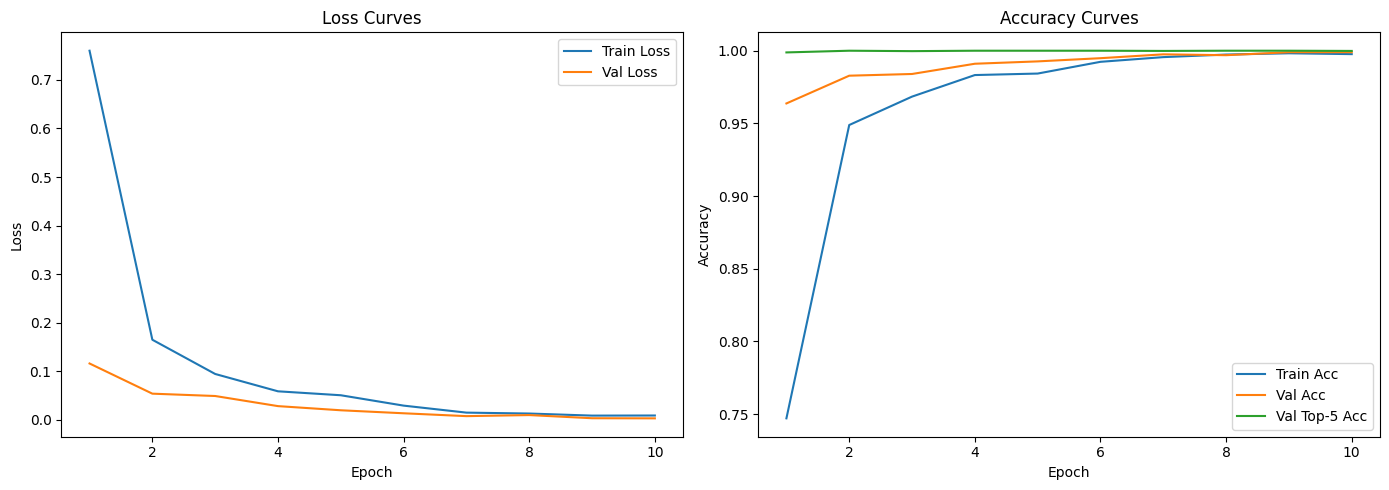

In [8]:
# Plot Loss and Accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(14,5))
# Loss
axs[0].plot(range(1, epochs+1), train_losses, label='Train Loss')
axs[0].plot(range(1, epochs+1), val_losses,   label='Val Loss')
axs[0].set_title('Loss Curves')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(range(1, epochs+1), train_accs,     label='Train Acc')
axs[1].plot(range(1, epochs+1), val_accs,       label='Val Acc')
axs[1].plot(range(1, epochs+1), val_top5_accs,  label='Val Top-5 Acc')
axs[1].set_title('Accuracy Curves')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

Test Eval: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]



Test Accuracy   : 98.30%
Macro Precision : 98.26%
Macro Recall    : 98.30%
Test Top-5 Acc  : 99.93%

Classification Report:
                precision    recall  f1-score   support

   Mazda-2000     1.0000    0.9891    0.9945        92
Nissan-Zamiad     0.9889    1.0000    0.9944        89
  Peugeot-206     0.9746    0.9664    0.9705       119
 Peugeot-207i     0.9492    1.0000    0.9739       112
  Peugeot-405     0.9444    0.9551    0.9497        89
 Peugeot-Pars     0.9817    0.9554    0.9683       112
       Peykan     0.9914    1.0000    0.9957       115
    Pride-111     0.9920    0.9538    0.9725       130
    Pride-131     0.9826    1.0000    0.9912       113
         Quik     0.9869    0.9934    0.9902       152
  Renault-L90     0.9898    0.9898    0.9898        98
       Samand     1.0000    0.9843    0.9921       127
        Tiba2     0.9921    0.9921    0.9921       126

     accuracy                         0.9830      1474
    macro avg     0.9826    0.9830    0.9827   

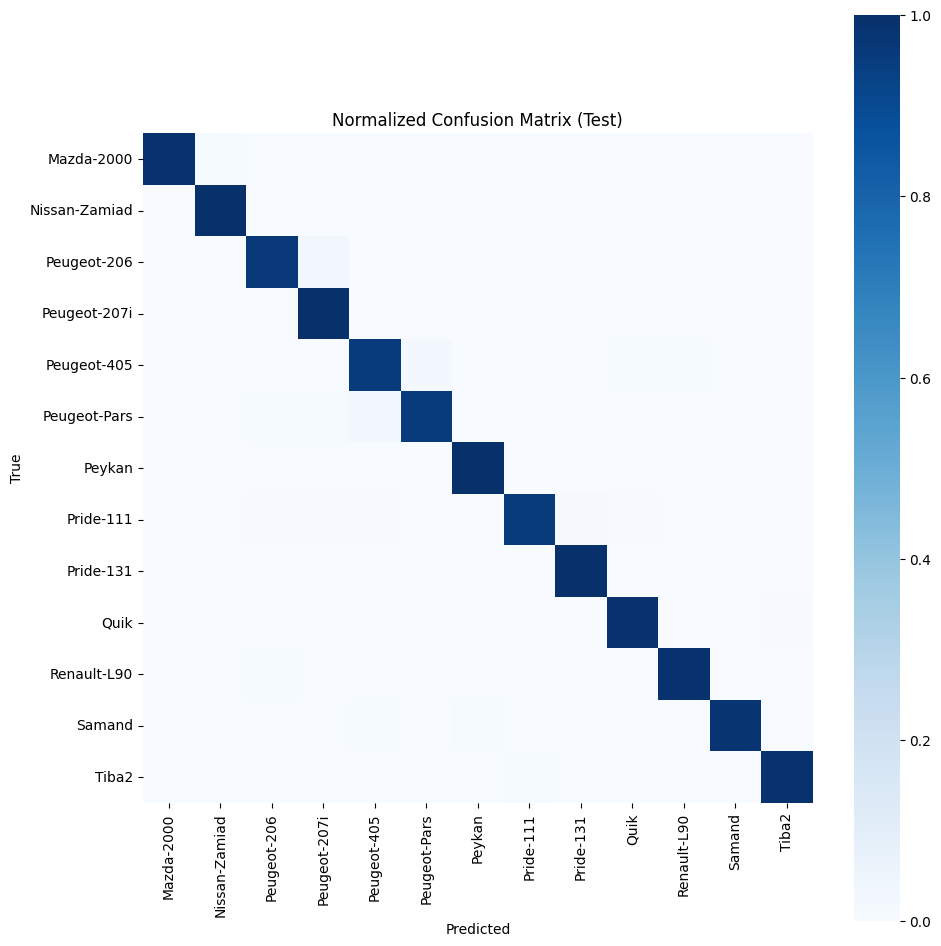

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
model.eval()
all_preds, all_trues = [], []
all_logits = []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Test Eval"):
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())
        all_logits.append(out.cpu())
all_logits = torch.cat(all_logits)

# Metrics
acc    = accuracy_score(all_trues, all_preds)
prec   = precision_score(all_trues, all_preds, average='macro')
recall = recall_score(all_trues, all_preds, average='macro')
report = classification_report(all_trues, all_preds, target_names=train_ds.classes, digits=4)
cm     = confusion_matrix(all_trues, all_preds, normalize='true')
top5   = torch.topk(all_logits, 5, dim=1).indices
test_top5 = (top5 == torch.tensor(all_trues).unsqueeze(1)).any(dim=1).float().mean().item()

print(f"\nTest Accuracy   : {acc*100:.2f}%")
print(f"Macro Precision : {prec*100:.2f}%")
print(f"Macro Recall    : {recall*100:.2f}%")
print(f"Test Top-5 Acc  : {test_top5*100:.2f}%\n")
print("Classification Report:\n", report)

plt.figure(figsize=(10,10))
sns.heatmap(cm, xticklabels=train_ds.classes, yticklabels=train_ds.classes,
            cmap='Blues', square=True)
plt.title("Normalized Confusion Matrix (Test)")
plt.xlabel("Predicted"), plt.ylabel("True")
plt.tight_layout()
plt.show()

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=8):
        super().__init__()
        self.embed_dim = in_channels
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(
            embed_dim=in_channels, num_heads=num_heads, batch_first=True
        )
    def forward(self, x):
        # x: [B, C, H, W] -> [B, H*W, C]
        B, C, H, W = x.shape
        seq = x.view(B, C, H*W).permute(0, 2, 1)  # B, N, C
        attn_out, _ = self.mha(seq, seq, seq)
        # add & reshape
        out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return out + x  # residual

# 4) ResNet-50 + Self-Attention
from torchvision.models import resnet50
class ResNet50_SA(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        # inject self-attention after layer4
        in_ch = self.backbone.layer4[-1].conv3.out_channels
        self.sa = SelfAttention(in_ch, num_heads=8)
        # replace classifier head
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x):
        # standard ResNet layers until layer4
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        # self-attention
        x = self.sa(x)
        # pool & classify
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        return self.backbone.fc(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ResNet50_SA(num_classes=len(train_ds.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [19]:
# Containers for metrics
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_top5_accs = []

# Training loop with validation
for epoch in range(1, epochs+1):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds==y).sum().item()
        total += x.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    top5_correct = 0
    with torch.no_grad():
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds==y).sum().item()
            val_total += x.size(0)
            # Top-5 accuracy
            top5 = torch.topk(logits, k=5, dim=1).indices
            top5_correct += sum([1 if y[i] in top5[i] else 0 for i in range(y.size(0))])
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    top5_acc = top5_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_top5_accs.append(top5_acc)

    scheduler.step()
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, Top-5 Acc={top5_acc:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.89it/s]


Epoch 1: Train Loss=0.6189, Acc=0.8038 | Val Loss=0.3238, Acc=0.9004, Top-5 Acc=0.9872


Epoch 2/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.65it/s]


Epoch 2: Train Loss=0.1838, Acc=0.9410 | Val Loss=0.1818, Acc=0.9460, Top-5 Acc=0.9959


Epoch 3/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.97it/s]


Epoch 3: Train Loss=0.1032, Acc=0.9674 | Val Loss=0.0499, Acc=0.9843, Top-5 Acc=0.9994


Epoch 4/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  8.02it/s]


Epoch 4: Train Loss=0.0807, Acc=0.9746 | Val Loss=0.0373, Acc=0.9877, Top-5 Acc=0.9997


Epoch 5/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.66it/s]


Epoch 5: Train Loss=0.0511, Acc=0.9844 | Val Loss=0.0296, Acc=0.9913, Top-5 Acc=0.9997


Epoch 6/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.99it/s]


Epoch 6: Train Loss=0.0373, Acc=0.9868 | Val Loss=0.0249, Acc=0.9935, Top-5 Acc=0.9999


Epoch 7/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.97it/s]


Epoch 7: Train Loss=0.0209, Acc=0.9934 | Val Loss=0.0084, Acc=0.9978, Top-5 Acc=1.0000


Epoch 8/10 [Val]: 100%|██████████| 107/107 [00:14<00:00,  7.51it/s]


Epoch 8: Train Loss=0.0130, Acc=0.9963 | Val Loss=0.0074, Acc=0.9979, Top-5 Acc=1.0000


Epoch 9/10 [Val]: 100%|██████████| 107/107 [00:13<00:00,  7.96it/s]


Epoch 9: Train Loss=0.0082, Acc=0.9977 | Val Loss=0.0056, Acc=0.9990, Top-5 Acc=1.0000


Epoch 10/10 [Val]: 100%|██████████| 107/107 [00:14<00:00,  7.62it/s]

Epoch 10: Train Loss=0.0073, Acc=0.9982 | Val Loss=0.0066, Acc=0.9985, Top-5 Acc=1.0000


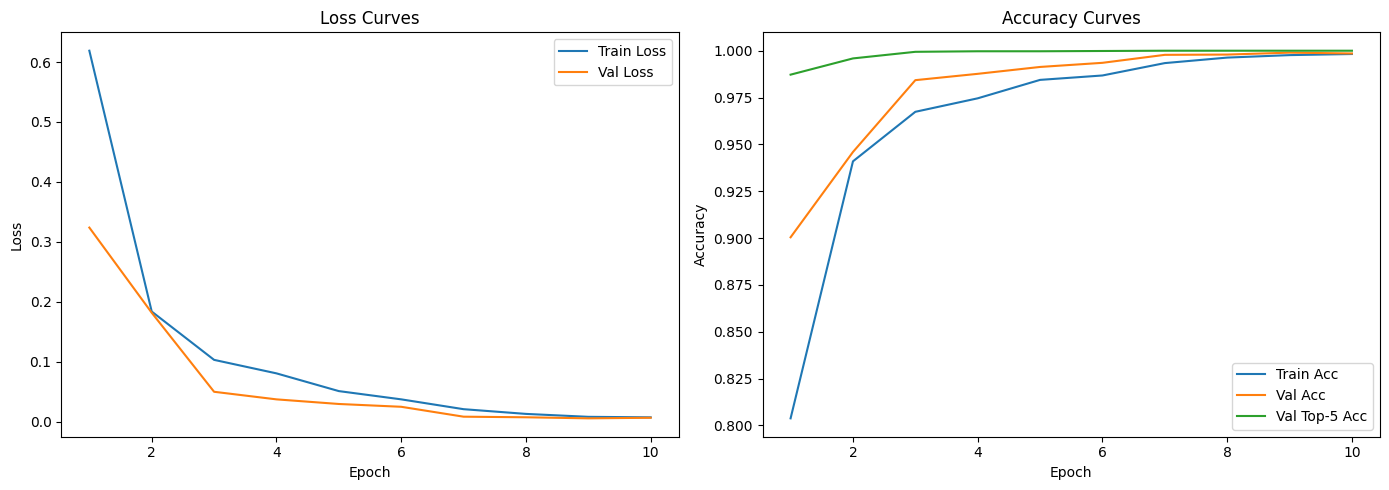

In [21]:
# Plot Loss and Accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(14,5))
# Loss
axs[0].plot(range(1, epochs+1), train_losses, label='Train Loss')
axs[0].plot(range(1, epochs+1), val_losses,   label='Val Loss')
axs[0].set_title('Loss Curves')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(range(1, epochs+1), train_accs,     label='Train Acc')
axs[1].plot(range(1, epochs+1), val_accs,       label='Val Acc')
axs[1].plot(range(1, epochs+1), val_top5_accs,  label='Val Top-5 Acc')
axs[1].set_title('Accuracy Curves')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

Test Eval: 100%|██████████| 24/24 [00:03<00:00,  6.76it/s]



Test Accuracy   : 98.44%
Macro Precision : 98.43%
Macro Recall    : 98.50%
Test Top-5 Acc  : 99.93%

Classification Report:
                precision    recall  f1-score   support

   Mazda-2000     1.0000    1.0000    1.0000        92
Nissan-Zamiad     1.0000    1.0000    1.0000        89
  Peugeot-206     0.9913    0.9580    0.9744       119
 Peugeot-207i     0.9739    1.0000    0.9868       112
  Peugeot-405     0.9263    0.9888    0.9565        89
 Peugeot-Pars     1.0000    0.9464    0.9725       112
       Peykan     1.0000    1.0000    1.0000       115
    Pride-111     1.0000    0.9769    0.9883       130
    Pride-131     0.9912    1.0000    0.9956       113
         Quik     0.9804    0.9868    0.9836       152
  Renault-L90     0.9796    0.9796    0.9796        98
       Samand     0.9920    0.9764    0.9841       127
        Tiba2     0.9615    0.9921    0.9766       126

     accuracy                         0.9844      1474
    macro avg     0.9843    0.9850    0.9845   

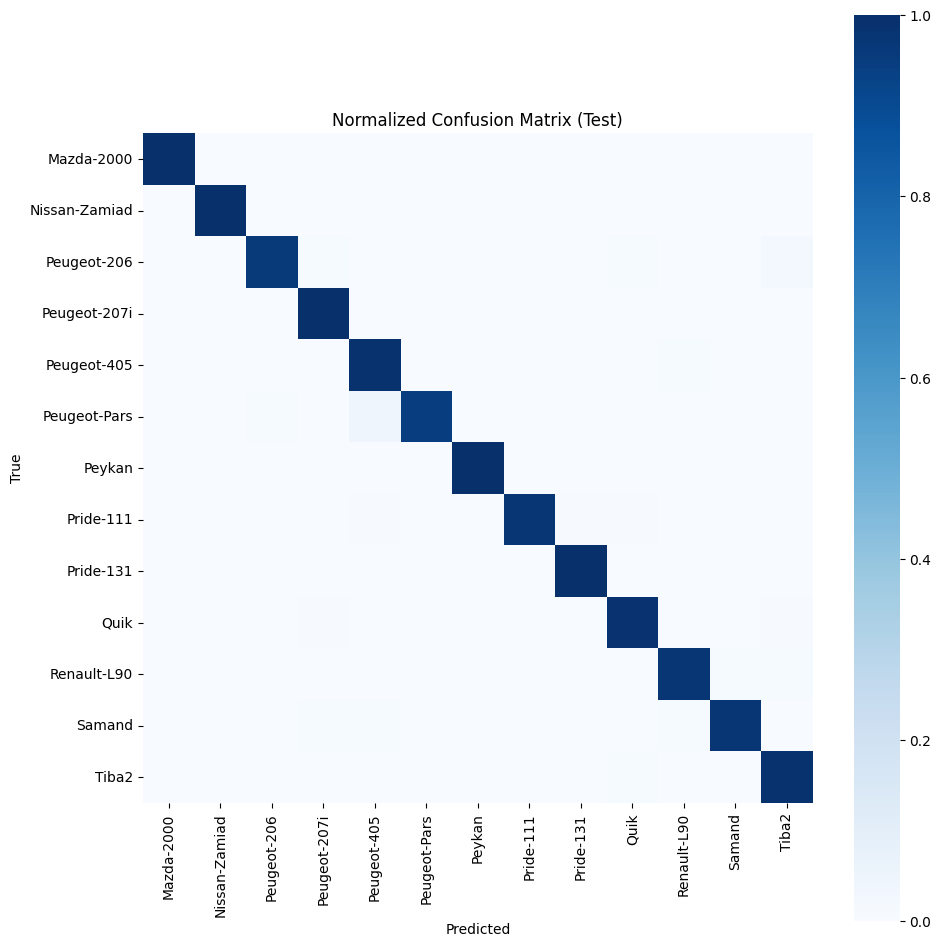

In [20]:
model.eval()
all_preds, all_trues = [], []
all_logits = []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Test Eval"):
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())
        all_logits.append(out.cpu())
all_logits = torch.cat(all_logits)

# Metrics
acc    = accuracy_score(all_trues, all_preds)
prec   = precision_score(all_trues, all_preds, average='macro')
recall = recall_score(all_trues, all_preds, average='macro')
report = classification_report(all_trues, all_preds, target_names=train_ds.classes, digits=4)
cm     = confusion_matrix(all_trues, all_preds, normalize='true')
top5   = torch.topk(all_logits, 5, dim=1).indices
test_top5 = (top5 == torch.tensor(all_trues).unsqueeze(1)).any(dim=1).float().mean().item()

print(f"\nTest Accuracy   : {acc*100:.2f}%")
print(f"Macro Precision : {prec*100:.2f}%")
print(f"Macro Recall    : {recall*100:.2f}%")
print(f"Test Top-5 Acc  : {test_top5*100:.2f}%\n")
print("Classification Report:\n", report)

plt.figure(figsize=(10,10))
sns.heatmap(cm, xticklabels=train_ds.classes, yticklabels=train_ds.classes,
            cmap='Blues', square=True)
plt.title("Normalized Confusion Matrix (Test)")
plt.xlabel("Predicted"), plt.ylabel("True")
plt.tight_layout()
plt.show()